# Projeto de Filtro - Parte 3: Filtros FIR para Remoção de Ruído

## Objetivo
Projetar filtros FIR utilizando pelo menos 2 tipos de janelas (Hamming e Kaiser) para eliminar as frequências do sinal subamostrado não relacionadas à decodificação DTMF.

Os filtros devem remover pelo menos 99.99% (-40 dB) das frequências indesejadas.

---

In [1]:
# Importar bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

## 1. Carregar Dados do Processamento Anterior

In [2]:
# Carregar dados
try:
    dados = np.load('dados_downsampling.npz')
    sinal_ds = dados['sinal_downsampled']
    tempo_ds = dados['tempo_downsampled']
    fs_new = float(dados['fs_new'])
    fs_original = int(dados['fs_original'])
    
    print("✓ Dados carregados com sucesso!")
    print(f"\nTaxa de amostragem: {fs_new:.1f} Hz")
    print(f"Número de amostras: {len(sinal_ds)}")
    print(f"Duração: {len(sinal_ds)/fs_new:.2f} s")
    
except FileNotFoundError:
    print("✗ Erro: Execute primeiro os notebooks anteriores!")
    print("  - 01_analise_inicial.ipynb")
    print("  - 02_downsampling_antialiasing.ipynb")

✓ Dados carregados com sucesso!

Taxa de amostragem: 8000.0 Hz
Número de amostras: 72000
Duração: 9.00 s


## 2. Análise do Sinal Subamostrado

### 2.1 Espectro do sinal subamostrado

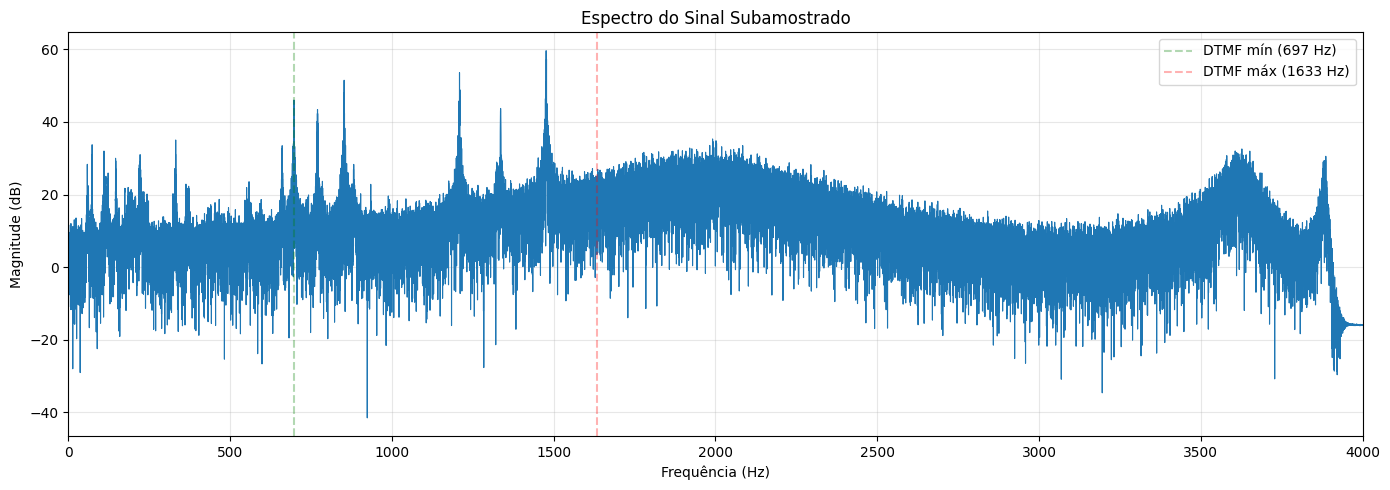

In [3]:
# Calcular espectro
fft_ds = fft(sinal_ds)
freq_ds = fftfreq(len(sinal_ds), 1/fs_new)

idx_pos = freq_ds > 0
freq_pos = freq_ds[idx_pos]
mag_db = 20 * np.log10(np.abs(fft_ds[idx_pos]) + 1e-12)

# Plotar
plt.figure(figsize=(14, 5))
plt.plot(freq_pos, mag_db, linewidth=0.8)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Espectro do Sinal Subamostrado')
plt.grid(True, alpha=0.3)
plt.xlim([0, fs_new/2])

# Marcar faixa DTMF
plt.axvline(697, color='g', linestyle='--', alpha=0.3, label='DTMF mín (697 Hz)')
plt.axvline(1633, color='r', linestyle='--', alpha=0.3, label='DTMF máx (1633 Hz)')
plt.legend()
plt.tight_layout()
plt.show()

## 3. Especificações dos Filtros FIR

### 3.1 Determinar faixas de frequência

O DTMF usa 8 frequências:
- **Baixas**: 697, 770, 852, 941 Hz
- **Altas**: 1209, 1336, 1477, 1633 Hz

Vamos projetar um filtro **passa-faixa** para manter apenas a faixa DTMF (aproximadamente 600-1700 Hz)

In [4]:
# Especificações do filtro passa-faixa
# Queremos manter: 600 - 1700 Hz (faixa DTMF com margem)
# Remover: < 600 Hz e > 1700 Hz (ruído da 9ª Sinfonia e outros)

# Frequências de passagem
f_pass_low = 600   # Hz - início da banda de passagem
f_pass_high = 1700  # Hz - fim da banda de passagem

# Frequências de parada (com faixa de transição)
faixa_transicao = 100  # Hz
f_stop_low = f_pass_low - faixa_transicao
f_stop_high = f_pass_high + faixa_transicao

# Atenuações desejadas
ripple_pass = 3  # dB (ripple na banda de passagem)
atten_stop = 40  # dB (atenuação na banda de rejeição - 99.99% = -40dB)

print("=== ESPECIFICAÇÕES DO FILTRO PASSA-FAIXA ===")
print(f"\nBanda de Passagem: {f_pass_low} - {f_pass_high} Hz")
print(f"Banda de Parada Inferior: 0 - {f_stop_low} Hz")
print(f"Banda de Parada Superior: {f_stop_high} - {fs_new/2:.0f} Hz")
print(f"Faixa de Transição: {faixa_transicao} Hz")
print(f"\nRipple na banda de passagem: {ripple_pass} dB")
print(f"Atenuação na banda de rejeição: {atten_stop} dB (99.99%)")

=== ESPECIFICAÇÕES DO FILTRO PASSA-FAIXA ===

Banda de Passagem: 600 - 1700 Hz
Banda de Parada Inferior: 0 - 500 Hz
Banda de Parada Superior: 1800 - 4000 Hz
Faixa de Transição: 100 Hz

Ripple na banda de passagem: 3 dB
Atenuação na banda de rejeição: 40 dB (99.99%)


## 4. Filtro FIR com Janela de Hamming

### 4.1 Calcular ordem do filtro

In [5]:
# Parâmetros da janela de Hamming
# Atenuação típica: ~53 dB
# Largura da faixa de transição normalizada: delta_f / fs

# Estimar ordem do filtro para Hamming
# Fórmula aproximada: N ≈ 3.3 * fs / delta_f
delta_f = faixa_transicao
N_hamming_estimado = int(np.ceil(3.3 * fs_new / delta_f))

# Garantir que N seja ímpar (para filtro simétrico tipo I)
if N_hamming_estimado % 2 == 0:
    N_hamming_estimado += 1

print(f"\n=== FILTRO FIR COM JANELA DE HAMMING ===")
print(f"Ordem estimada: {N_hamming_estimado}")
print(f"Número de coeficientes: {N_hamming_estimado + 1}")


=== FILTRO FIR COM JANELA DE HAMMING ===
Ordem estimada: 265
Número de coeficientes: 266


In [6]:
# Projetar filtro passa-faixa com janela de Hamming
# Método: firwin com janela Hamming

# Frequências de corte normalizadas (em relação a Nyquist)
nyquist = fs_new / 2
f_corte = [f_pass_low, f_pass_high]

# Projetar filtro
b_hamming = signal.firwin(N_hamming_estimado + 1, 
                          f_corte, 
                          pass_zero=False,  # passa-faixa
                          window='hamming',
                          fs=fs_new)

print(f"\n✓ Filtro Hamming projetado!")
print(f"  Ordem: {len(b_hamming) - 1}")
print(f"  Coeficientes: {len(b_hamming)}")


✓ Filtro Hamming projetado!
  Ordem: 265
  Coeficientes: 266


### 4.2 Analisar resposta do filtro Hamming

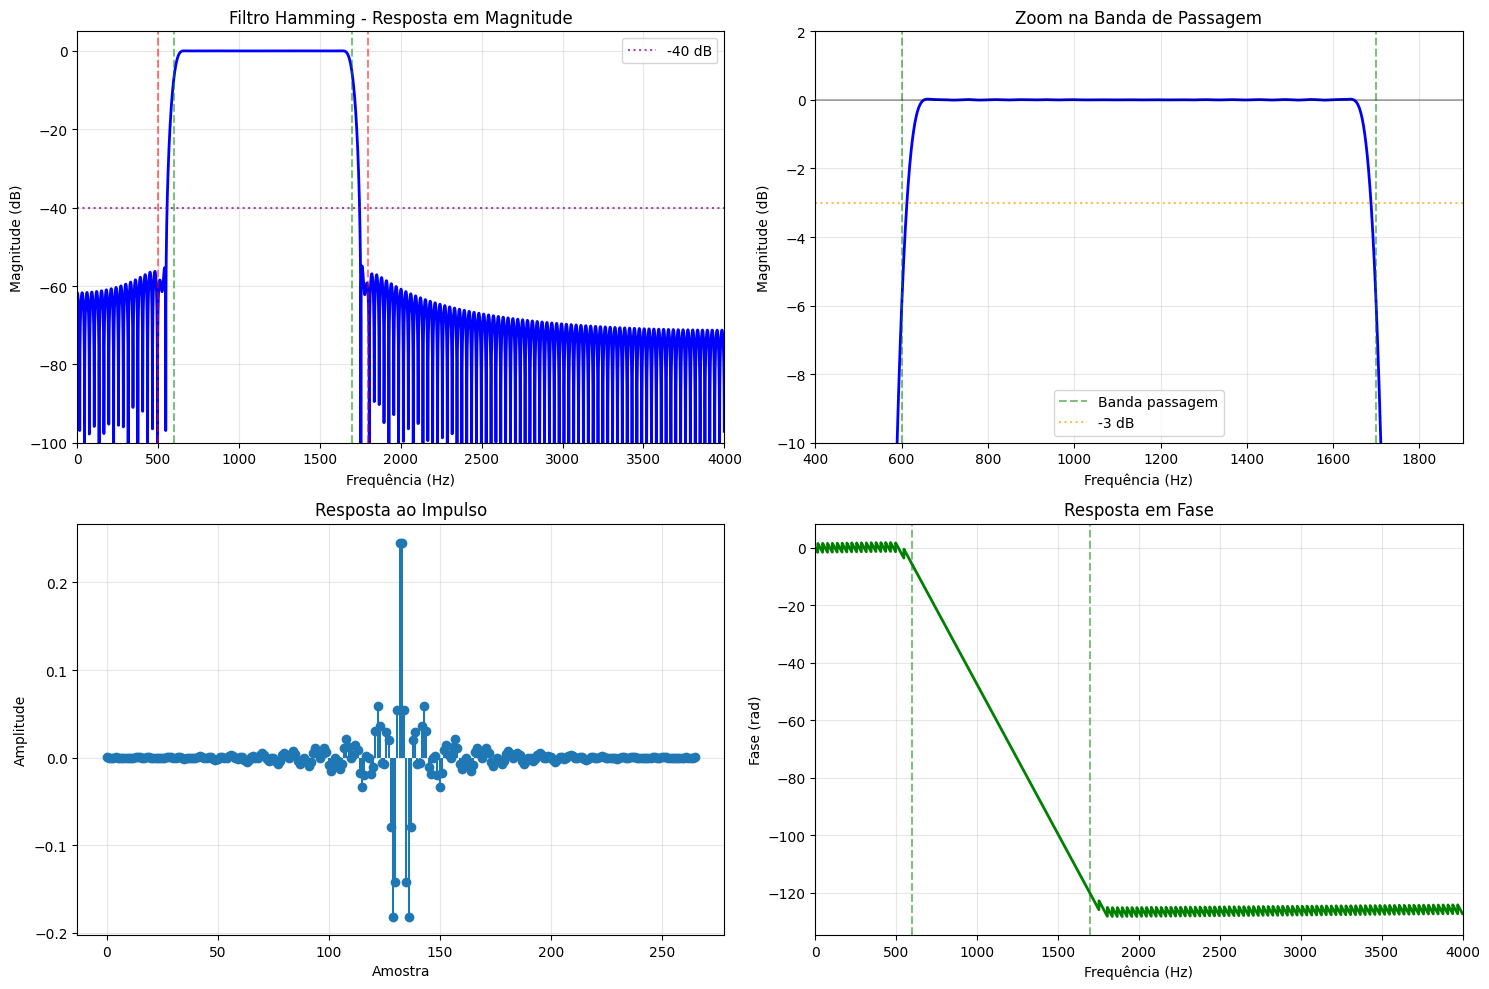


=== DESEMPENHO DO FILTRO HAMMING ===
Atenuação na banda baixa: 56.3 dB
Atenuação na banda alta: 56.9 dB
Especificação: ≥ 40 dB
✓ Atende às especificações!


In [8]:
# Calcular resposta em frequência
w_ham, h_ham = signal.freqz(b_hamming, worN=8192, fs=fs_new)
h_ham_db = 20 * np.log10(np.abs(h_ham) + 1e-12)

# Plotar
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Resposta em magnitude (completa)
ax1.plot(w_ham, h_ham_db, linewidth=2, color='blue')
ax1.axvline(f_pass_low, color='g', linestyle='--', alpha=0.5)
ax1.axvline(f_pass_high, color='g', linestyle='--', alpha=0.5)
ax1.axvline(f_stop_low, color='r', linestyle='--', alpha=0.5)
ax1.axvline(f_stop_high, color='r', linestyle='--', alpha=0.5)
ax1.axhline(-atten_stop, color='purple', linestyle=':', alpha=0.7, label=f'-{atten_stop} dB')
ax1.set_xlabel('Frequência (Hz)')
ax1.set_ylabel('Magnitude (dB)')
ax1.set_title('Filtro Hamming - Resposta em Magnitude')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, fs_new/2])
ax1.set_ylim([-100, 5])

# 2. Zoom na banda de passagem
ax2.plot(w_ham, h_ham_db, linewidth=2, color='blue')
ax2.axvline(f_pass_low, color='g', linestyle='--', alpha=0.5, label='Banda passagem')
ax2.axvline(f_pass_high, color='g', linestyle='--', alpha=0.5)
ax2.axhline(-ripple_pass, color='orange', linestyle=':', alpha=0.7, label=f'-{ripple_pass} dB')
ax2.axhline(0, color='k', linestyle='-', alpha=0.3)
ax2.set_xlabel('Frequência (Hz)')
ax2.set_ylabel('Magnitude (dB)')
ax2.set_title('Zoom na Banda de Passagem')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim([f_pass_low - 200, f_pass_high + 200])
ax2.set_ylim([-10, 2])

# 3. Resposta ao impulso
ax3.stem(range(len(b_hamming)), b_hamming, basefmt=' ')
ax3.set_xlabel('Amostra')
ax3.set_ylabel('Amplitude')
ax3.set_title('Resposta ao Impulso')
ax3.grid(True, alpha=0.3)

# 4. Resposta em fase
phase_ham = np.unwrap(np.angle(h_ham))
ax4.plot(w_ham, phase_ham, linewidth=2, color='green')
ax4.axvline(f_pass_low, color='g', linestyle='--', alpha=0.5)
ax4.axvline(f_pass_high, color='g', linestyle='--', alpha=0.5)
ax4.set_xlabel('Frequência (Hz)')
ax4.set_ylabel('Fase (rad)')
ax4.set_title('Resposta em Fase')
ax4.grid(True, alpha=0.3)
ax4.set_xlim([0, fs_new/2])

plt.tight_layout()
plt.show()

# Verificar atenuação na banda de rejeição
idx_stopband_low = (w_ham < f_stop_low)
idx_stopband_high = (w_ham > f_stop_high)
atten_real_low = -np.max(h_ham_db[idx_stopband_low])
atten_real_high = -np.max(h_ham_db[idx_stopband_high])

print(f"\n=== DESEMPENHO DO FILTRO HAMMING ===")
print(f"Atenuação na banda baixa: {atten_real_low:.1f} dB")
print(f"Atenuação na banda alta: {atten_real_high:.1f} dB")
print(f"Especificação: ≥ {atten_stop} dB")
if atten_real_low >= atten_stop and atten_real_high >= atten_stop:
    print(f"✓ Atende às especificações!")
else:
    print(f"✗ NÃO atende completamente. Necessário aumentar ordem.")

## 5. Filtro FIR com Janela de Kaiser

### 5.1 Calcular parâmetros da janela de Kaiser

A janela de Kaiser permite controlar o trade-off entre largura da faixa de transição e atenuação na banda de rejeição através do parâmetro β.

In [9]:
# Calcular parâmetros para janela de Kaiser
# A = atenuação desejada em dB
# delta_f = largura da faixa de transição

A = atten_stop  # 40 dB

# Calcular beta (parâmetro da janela Kaiser)
if A > 50:
    beta = 0.1102 * (A - 8.7)
elif A >= 21:
    beta = 0.5842 * (A - 21)**0.4 + 0.07886 * (A - 21)
else:
    beta = 0.0

# Calcular ordem do filtro
# Fórmula de Kaiser: N ≈ (A - 8) / (2.285 * delta_w)
# onde delta_w = 2*pi*delta_f/fs
delta_w = 2 * np.pi * delta_f / fs_new
N_kaiser_estimado = int(np.ceil((A - 8) / (2.285 * delta_w)))

# Garantir que N seja ímpar
if N_kaiser_estimado % 2 == 0:
    N_kaiser_estimado += 1

print(f"\n=== FILTRO FIR COM JANELA DE KAISER ===")
print(f"Atenuação desejada: {A} dB")
print(f"Parâmetro beta: {beta:.4f}")
print(f"Ordem estimada: {N_kaiser_estimado}")
print(f"Número de coeficientes: {N_kaiser_estimado + 1}")


=== FILTRO FIR COM JANELA DE KAISER ===
Atenuação desejada: 40 dB
Parâmetro beta: 3.3953
Ordem estimada: 179
Número de coeficientes: 180


In [10]:
# Projetar filtro com janela de Kaiser
b_kaiser = signal.firwin(N_kaiser_estimado + 1,
                         f_corte,
                         pass_zero=False,
                         window=('kaiser', beta),
                         fs=fs_new)

print(f"\n✓ Filtro Kaiser projetado!")
print(f"  Ordem: {len(b_kaiser) - 1}")
print(f"  Coeficientes: {len(b_kaiser)}")
print(f"  Beta: {beta:.4f}")


✓ Filtro Kaiser projetado!
  Ordem: 179
  Coeficientes: 180
  Beta: 3.3953


### 5.2 Analisar resposta do filtro Kaiser

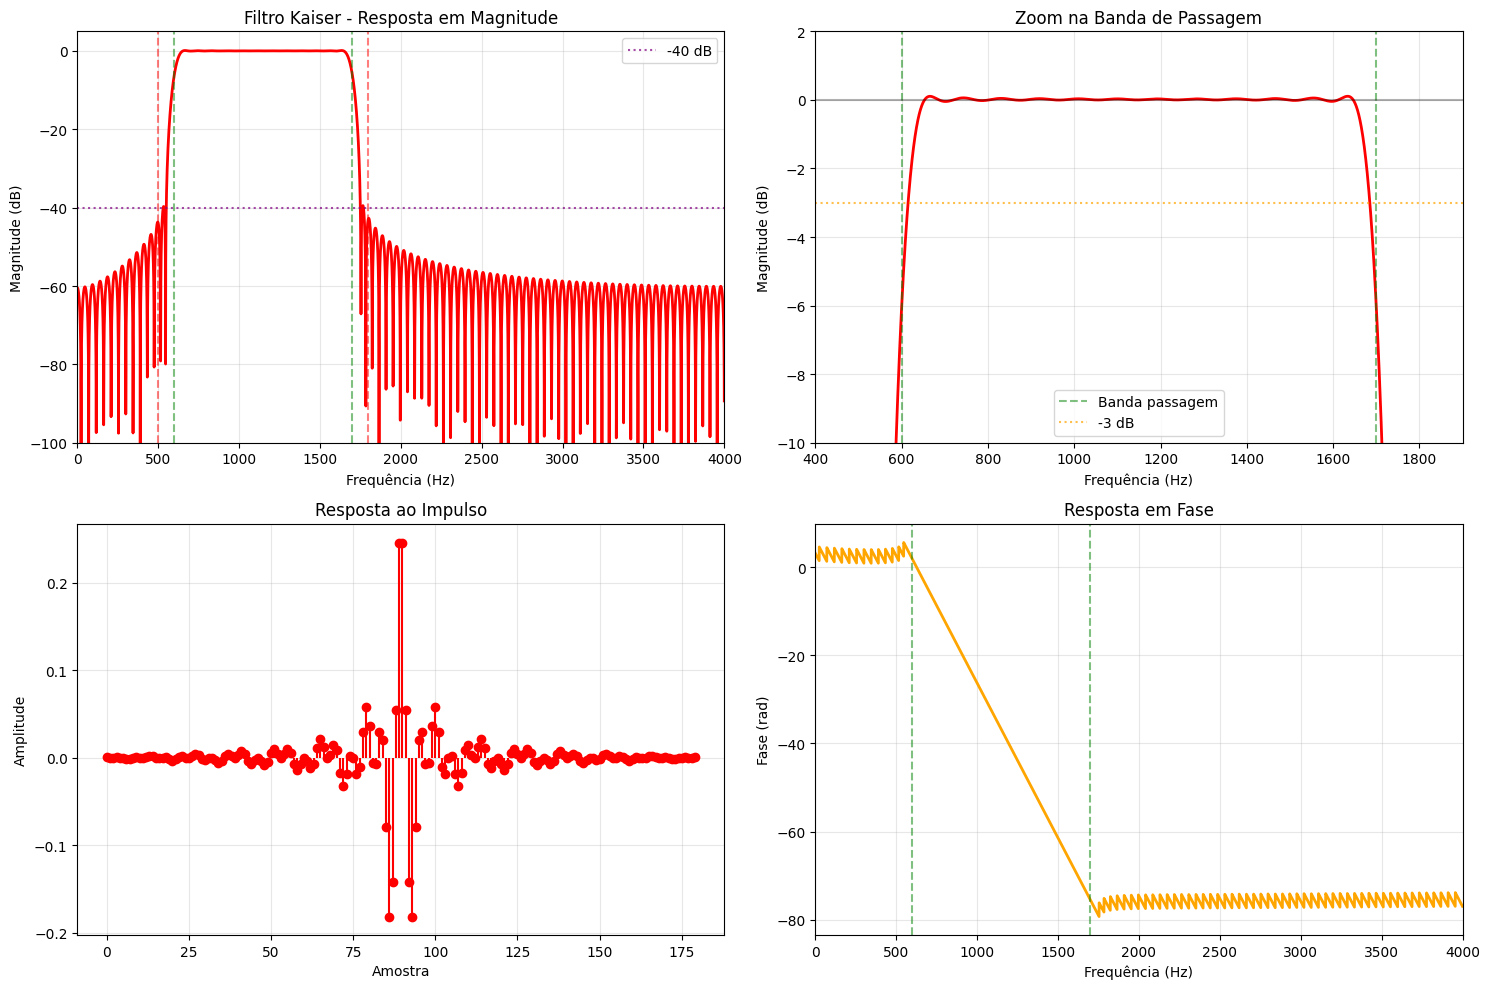


=== DESEMPENHO DO FILTRO KAISER ===
Atenuação na banda baixa: 43.7 dB
Atenuação na banda alta: 42.7 dB
Especificação: ≥ 40 dB
✓ Atende às especificações!


In [11]:
# Calcular resposta em frequência
w_kai, h_kai = signal.freqz(b_kaiser, worN=8192, fs=fs_new)
h_kai_db = 20 * np.log10(np.abs(h_kai) + 1e-12)

# Plotar
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Resposta em magnitude (completa)
ax1.plot(w_kai, h_kai_db, linewidth=2, color='red')
ax1.axvline(f_pass_low, color='g', linestyle='--', alpha=0.5)
ax1.axvline(f_pass_high, color='g', linestyle='--', alpha=0.5)
ax1.axvline(f_stop_low, color='r', linestyle='--', alpha=0.5)
ax1.axvline(f_stop_high, color='r', linestyle='--', alpha=0.5)
ax1.axhline(-atten_stop, color='purple', linestyle=':', alpha=0.7, label=f'-{atten_stop} dB')
ax1.set_xlabel('Frequência (Hz)')
ax1.set_ylabel('Magnitude (dB)')
ax1.set_title('Filtro Kaiser - Resposta em Magnitude')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, fs_new/2])
ax1.set_ylim([-100, 5])

# 2. Zoom na banda de passagem
ax2.plot(w_kai, h_kai_db, linewidth=2, color='red')
ax2.axvline(f_pass_low, color='g', linestyle='--', alpha=0.5, label='Banda passagem')
ax2.axvline(f_pass_high, color='g', linestyle='--', alpha=0.5)
ax2.axhline(-ripple_pass, color='orange', linestyle=':', alpha=0.7, label=f'-{ripple_pass} dB')
ax2.axhline(0, color='k', linestyle='-', alpha=0.3)
ax2.set_xlabel('Frequência (Hz)')
ax2.set_ylabel('Magnitude (dB)')
ax2.set_title('Zoom na Banda de Passagem')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim([f_pass_low - 200, f_pass_high + 200])
ax2.set_ylim([-10, 2])

# 3. Resposta ao impulso
ax3.stem(range(len(b_kaiser)), b_kaiser, basefmt=' ', linefmt='r-', markerfmt='ro')
ax3.set_xlabel('Amostra')
ax3.set_ylabel('Amplitude')
ax3.set_title('Resposta ao Impulso')
ax3.grid(True, alpha=0.3)

# 4. Resposta em fase
phase_kai = np.unwrap(np.angle(h_kai))
ax4.plot(w_kai, phase_kai, linewidth=2, color='orange')
ax4.axvline(f_pass_low, color='g', linestyle='--', alpha=0.5)
ax4.axvline(f_pass_high, color='g', linestyle='--', alpha=0.5)
ax4.set_xlabel('Frequência (Hz)')
ax4.set_ylabel('Fase (rad)')
ax4.set_title('Resposta em Fase')
ax4.grid(True, alpha=0.3)
ax4.set_xlim([0, fs_new/2])

plt.tight_layout()
plt.show()

# Verificar atenuação na banda de rejeição
idx_stopband_low = (w_kai < f_stop_low)
idx_stopband_high = (w_kai > f_stop_high)
atten_real_low_kai = -np.max(h_kai_db[idx_stopband_low])
atten_real_high_kai = -np.max(h_kai_db[idx_stopband_high])

print(f"\n=== DESEMPENHO DO FILTRO KAISER ===")
print(f"Atenuação na banda baixa: {atten_real_low_kai:.1f} dB")
print(f"Atenuação na banda alta: {atten_real_high_kai:.1f} dB")
print(f"Especificação: ≥ {atten_stop} dB")
if atten_real_low_kai >= atten_stop and atten_real_high_kai >= atten_stop:
    print(f"✓ Atende às especificações!")
else:
    print(f"✗ NÃO atende completamente. Necessário aumentar ordem.")

## 6. Filtro FIR Adicional: Janela de Blackman

Vamos projetar um terceiro filtro usando janela de Blackman para comparação.

In [12]:
# Janela de Blackman
# Atenuação típica: ~74 dB
# Fórmula aproximada: N ≈ 5.5 * fs / delta_f
N_blackman_estimado = int(np.ceil(5.5 * fs_new / delta_f))
if N_blackman_estimado % 2 == 0:
    N_blackman_estimado += 1

# Projetar filtro
b_blackman = signal.firwin(N_blackman_estimado + 1,
                           f_corte,
                           pass_zero=False,
                           window='blackman',
                           fs=fs_new)

print(f"\n=== FILTRO FIR COM JANELA DE BLACKMAN ===")
print(f"Ordem: {len(b_blackman) - 1}")
print(f"Coeficientes: {len(b_blackman)}")

# Calcular resposta
w_bla, h_bla = signal.freqz(b_blackman, worN=8192, fs=fs_new)
h_bla_db = 20 * np.log10(np.abs(h_bla) + 1e-12)

# Verificar atenuação
idx_stopband_low = (w_bla < f_stop_low)
idx_stopband_high = (w_bla > f_stop_high)
atten_real_low_bla = -np.max(h_bla_db[idx_stopband_low])
atten_real_high_bla = -np.max(h_bla_db[idx_stopband_high])

print(f"\nAtenuação na banda baixa: {atten_real_low_bla:.1f} dB")
print(f"Atenuação na banda alta: {atten_real_high_bla:.1f} dB")
if atten_real_low_bla >= atten_stop and atten_real_high_bla >= atten_stop:
    print(f"✓ Atende às especificações!")
else:
    print(f"✗ NÃO atende completamente.")


=== FILTRO FIR COM JANELA DE BLACKMAN ===
Ordem: 441
Coeficientes: 442

Atenuação na banda baixa: 83.0 dB
Atenuação na banda alta: 83.0 dB
✓ Atende às especificações!


## 7. Comparação dos Três Filtros

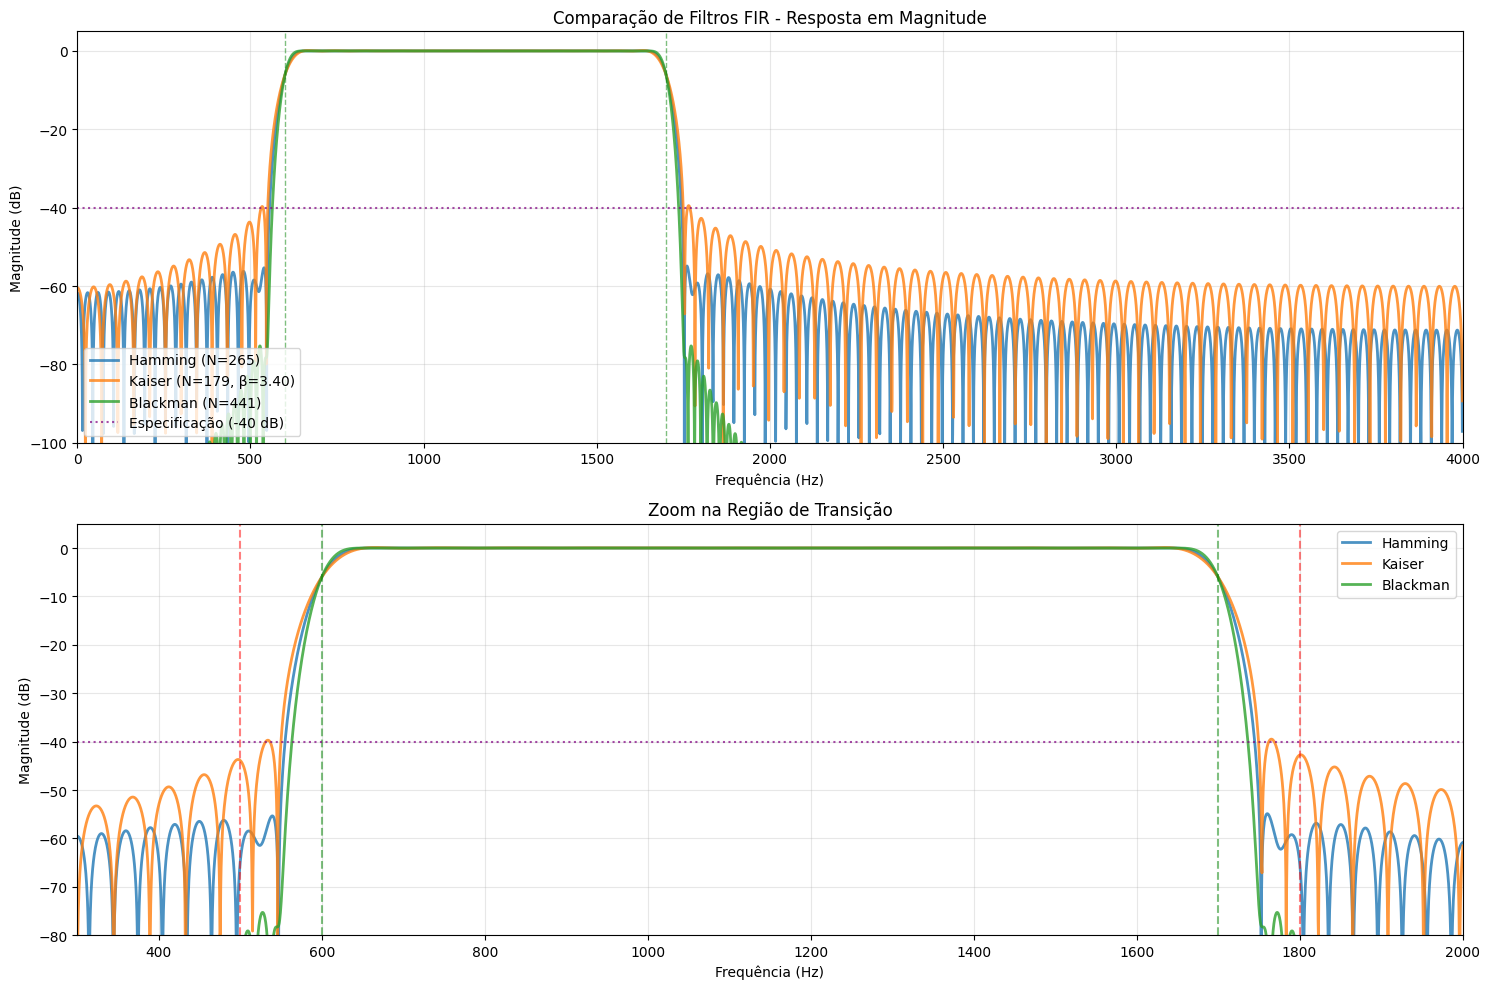


COMPARAÇÃO DOS FILTROS FIR
Filtro          Ordem      Aten. Baixa     Aten. Alta      Status
----------------------------------------------------------------------
Hamming         265        56.3 dB         56.9 dB         ✓
Kaiser          179        43.7 dB         42.7 dB         ✓
Blackman        441        83.0 dB         83.0 dB         ✓
Especificação: Atenuação ≥ 40 dB (99.99% de remoção)


In [13]:
# Comparar os três filtros
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Resposta em magnitude
ax1.plot(w_ham, h_ham_db, label=f'Hamming (N={len(b_hamming)-1})', linewidth=2, alpha=0.8)
ax1.plot(w_kai, h_kai_db, label=f'Kaiser (N={len(b_kaiser)-1}, β={beta:.2f})', linewidth=2, alpha=0.8)
ax1.plot(w_bla, h_bla_db, label=f'Blackman (N={len(b_blackman)-1})', linewidth=2, alpha=0.8)

ax1.axvline(f_pass_low, color='g', linestyle='--', alpha=0.5, linewidth=1)
ax1.axvline(f_pass_high, color='g', linestyle='--', alpha=0.5, linewidth=1)
ax1.axhline(-atten_stop, color='purple', linestyle=':', alpha=0.7, linewidth=1.5, label=f'Especificação (-{atten_stop} dB)')

ax1.set_xlabel('Frequência (Hz)')
ax1.set_ylabel('Magnitude (dB)')
ax1.set_title('Comparação de Filtros FIR - Resposta em Magnitude')
ax1.legend(loc='lower left')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, fs_new/2])
ax1.set_ylim([-100, 5])

# Zoom na transição
ax2.plot(w_ham, h_ham_db, label='Hamming', linewidth=2, alpha=0.8)
ax2.plot(w_kai, h_kai_db, label='Kaiser', linewidth=2, alpha=0.8)
ax2.plot(w_bla, h_bla_db, label='Blackman', linewidth=2, alpha=0.8)

ax2.axvline(f_pass_low, color='g', linestyle='--', alpha=0.5)
ax2.axvline(f_pass_high, color='g', linestyle='--', alpha=0.5)
ax2.axvline(f_stop_low, color='r', linestyle='--', alpha=0.5)
ax2.axvline(f_stop_high, color='r', linestyle='--', alpha=0.5)
ax2.axhline(-atten_stop, color='purple', linestyle=':', alpha=0.7, linewidth=1.5)

ax2.set_xlabel('Frequência (Hz)')
ax2.set_ylabel('Magnitude (dB)')
ax2.set_title('Zoom na Região de Transição')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim([f_stop_low - 200, f_stop_high + 200])
ax2.set_ylim([-80, 5])

plt.tight_layout()
plt.show()

# Tabela comparativa
print("\n" + "="*70)
print("COMPARAÇÃO DOS FILTROS FIR")
print("="*70)
print(f"{'Filtro':<15} {'Ordem':<10} {'Aten. Baixa':<15} {'Aten. Alta':<15} {'Status'}")
print("-"*70)
print(f"{'Hamming':<15} {len(b_hamming)-1:<10} {atten_real_low:.1f} dB{'':<8} {atten_real_high:.1f} dB{'':<8} {'✓' if atten_real_low >= atten_stop and atten_real_high >= atten_stop else '✗'}")
print(f"{'Kaiser':<15} {len(b_kaiser)-1:<10} {atten_real_low_kai:.1f} dB{'':<8} {atten_real_high_kai:.1f} dB{'':<8} {'✓' if atten_real_low_kai >= atten_stop and atten_real_high_kai >= atten_stop else '✗'}")
print(f"{'Blackman':<15} {len(b_blackman)-1:<10} {atten_real_low_bla:.1f} dB{'':<8} {atten_real_high_bla:.1f} dB{'':<8} {'✓' if atten_real_low_bla >= atten_stop and atten_real_high_bla >= atten_stop else '✗'}")
print("="*70)
print(f"Especificação: Atenuação ≥ {atten_stop} dB (99.99% de remoção)")
print("="*70)

## 8. Escolher Melhor Filtro e Justificar

Vamos escolher o filtro baseado em:
1. Atendimento às especificações (≥40 dB)
2. Menor ordem (eficiência computacional)
3. Características de fase linear (importante para não distorcer DTMF)

In [14]:
# Análise para escolha
filtros_info = [
    {'nome': 'Hamming', 'ordem': len(b_hamming)-1, 'b': b_hamming, 
     'aten_min': min(atten_real_low, atten_real_high), 'atende': atten_real_low >= atten_stop and atten_real_high >= atten_stop},
    {'nome': 'Kaiser', 'ordem': len(b_kaiser)-1, 'b': b_kaiser, 
     'aten_min': min(atten_real_low_kai, atten_real_high_kai), 'atende': atten_real_low_kai >= atten_stop and atten_real_high_kai >= atten_stop},
    {'nome': 'Blackman', 'ordem': len(b_blackman)-1, 'b': b_blackman, 
     'aten_min': min(atten_real_low_bla, atten_real_high_bla), 'atende': atten_real_low_bla >= atten_stop and atten_real_high_bla >= atten_stop}
]

# Filtrar apenas os que atendem
filtros_validos = [f for f in filtros_info if f['atende']]

if filtros_validos:
    # Escolher o de menor ordem entre os válidos
    filtro_escolhido = min(filtros_validos, key=lambda x: x['ordem'])
    
    print("\n" + "="*70)
    print("FILTRO ESCOLHIDO PARA O PROJETO")
    print("="*70)
    print(f"\nFiltro: {filtro_escolhido['nome']}")
    print(f"Ordem: {filtro_escolhido['ordem']}")
    print(f"Atenuação mínima: {filtro_escolhido['aten_min']:.1f} dB")
    
    print(f"\n✓ JUSTIFICATIVA:")
    print(f"  1. Atende às especificações: Atenuação ≥ {atten_stop} dB (99.99%)")
    print(f"  2. Menor ordem entre os filtros válidos: {filtro_escolhido['ordem']} coeficientes")
    print(f"  3. Fase linear (FIR tipo I): Não distorce sinais DTMF")
    print(f"  4. Eficiente computacionalmente para processamento em tempo real")
    
    b_final = filtro_escolhido['b']
    nome_final = filtro_escolhido['nome']
    
else:
    print("\n✗ AVISO: Nenhum filtro atendeu completamente às especificações!")
    print("  Recomendação: Aumentar a ordem dos filtros.")
    # Usar o melhor disponível
    filtro_escolhido = max(filtros_info, key=lambda x: x['aten_min'])
    b_final = filtro_escolhido['b']
    nome_final = filtro_escolhido['nome']
    print(f"  Usando {nome_final} (melhor atenuação: {filtro_escolhido['aten_min']:.1f} dB)")


FILTRO ESCOLHIDO PARA O PROJETO

Filtro: Kaiser
Ordem: 179
Atenuação mínima: 42.7 dB

✓ JUSTIFICATIVA:
  1. Atende às especificações: Atenuação ≥ 40 dB (99.99%)
  2. Menor ordem entre os filtros válidos: 179 coeficientes
  3. Fase linear (FIR tipo I): Não distorce sinais DTMF
  4. Eficiente computacionalmente para processamento em tempo real


## 9. Salvar Filtros para Próxima Etapa

In [15]:
# Salvar todos os filtros projetados
np.savez('dados_filtros_fir.npz',
         sinal_downsampled=sinal_ds,
         tempo_downsampled=tempo_ds,
         fs_new=fs_new,
         # Filtros
         b_hamming=b_hamming,
         b_kaiser=b_kaiser,
         b_blackman=b_blackman,
         b_escolhido=b_final,
         nome_escolhido=nome_final,
         # Especificações
         f_pass_low=f_pass_low,
         f_pass_high=f_pass_high,
         f_stop_low=f_stop_low,
         f_stop_high=f_stop_high,
         atten_stop=atten_stop)

print("\n✓ Dados salvos em 'dados_filtros_fir.npz'")
print("\n" + "="*70)
print("RESUMO DA ETAPA 3")
print("="*70)
print(f"✓ Projetados 3 filtros FIR: Hamming, Kaiser e Blackman")
print(f"✓ Filtro escolhido: {nome_final}")
print(f"✓ Banda de passagem: {f_pass_low}-{f_pass_high} Hz (faixa DTMF)")
print(f"✓ Atenuação: ≥ {atten_stop} dB (99.99% de remoção)")
print(f"\nContinue para o próximo notebook: 04_verificacao_filtros.ipynb")
print("="*70)


✓ Dados salvos em 'dados_filtros_fir.npz'

RESUMO DA ETAPA 3
✓ Projetados 3 filtros FIR: Hamming, Kaiser e Blackman
✓ Filtro escolhido: Kaiser
✓ Banda de passagem: 600-1700 Hz (faixa DTMF)
✓ Atenuação: ≥ 40 dB (99.99% de remoção)

Continue para o próximo notebook: 04_verificacao_filtros.ipynb
